In [1]:
import cv2
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tensorflow.keras.models import load_model
print(cv2.__version__)

4.5.2


In [2]:
# YOLO 설정 파일 Path
labelsPath = '/home/azure/passion/AI/YOLOv3/deepfashion2yolov3model/df2.names'
weightsPath = '/home/azure/passion/AI/YOLOv3/deepfashion2yolov3model/yolov3-df2_15000.weights'
configPath = '/home/azure/passion/AI/YOLOv3/deepfashion2yolov3model/yolov3-df2.cfg'


In [3]:
# YOLO 라벨(hand) 호출
YOLO_LABELS = open(labelsPath).read().strip().split("\n")
print(YOLO_LABELS)


# YOLO 모델 호출
yolo_net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

# YOLO 출력층 설정
layer_names = yolo_net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in yolo_net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(YOLO_LABELS), 3))

# 영상 할당
file_path = "/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/static/blouse2.jpg"
cap = cv2.VideoCapture(file_path)

# 화면 폰트
font = cv2.FONT_HERSHEY_COMPLEX_SMALL

_, frame = cap.read()
height, width, channels = frame.shape

['short_sleeve_top', 'long_sleeve_top', 'short_sleeve_outwear', 'long_sleeve_outwear', 'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short_sleeve_dress', 'long_sleeve_dress', 'vest_dress', 'sling_dress']


In [4]:
# Detecting objects
blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

yolo_net.setInput(blob)
outs = yolo_net.forward(output_layers)

# Showing informations on the screen
count = 0
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
#         print(detection)
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            count += 1
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            ww = int(detection[2] * width)
            hh = int(detection[3] * height)

            # Rectangle coordinates
            xx = int(center_x - ww / 2)
            yy = int(center_y - hh / 2)

            boxes.append([xx, yy, ww, hh])
            confidences.append(float(confidence))
            class_ids.append(class_id)
            
            crop_label = YOLO_LABELS[class_id]
            print(YOLO_LABELS[class_id]) # short sleeve top, shorts

            crop_img = frame[yy:yy + hh, xx:xx + hh]
            cv2.imwrite('/home/azure/passion/AI/YOLOv3/image/' +  crop_label + "_" + str(count) + "_" + str(confidence) + ".jpg", crop_img)


indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.8, 0.3)

long_sleeve_top
trousers
trousers


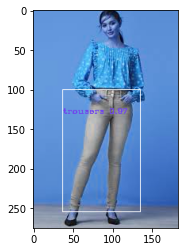

In [5]:
# 화면에 바운딩 박스 그리기
for i in range(len(boxes)):
    if i in indexes:
        boxes = np.array(boxes)
        x, y, w, h = boxes[i]
        label = str(YOLO_LABELS[class_ids[i]])
        confidence = confidences[i]
        color = colors[class_ids[i]]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 255), 1)
        cv2.putText(frame, label + " " + str(round(confidence, 2)), (x, y + 30), font, 0.5, color, 1)
        
# 디스플레이
plt.imshow(frame)
key = cv2.waitKey(0)

cap.release()